# Exploring NBA subreddits and submissions

## An interactive look with a Python data stack (pandas,matplotlib,sqlite3,praw)

**Author**: [Nabeel Hussain](n.hussain@protonmail.com)

**Overview**: In this notebook we will mine data from [reddit](www.reddit.com) with the [praw reddit api wrapper](https://praw.readthedocs.io/en/latest/). We will look at the main [nba subreddit](https://www.reddit.com/r/nba) and also all 32 team's subreddits (e.g [Los Angeles Lakers](https://www.reddit.com/r/lakers), [Boston Celtics](https://www.reddit.com/r/celtics)).
Once we store our data in a local sqlite3 database we will push sql queries to pull our data and use python libraries such as pandas, matplotlib and numpy to analyize and visualize some general facts about reddits NBA community.



### Building the reddit nba sql database 

The two following scripts accomplish the task of getting the data and building the local SQL database: 

**1. [NBA Subreddit Data Pull](https://github.com/nabeel-h/port.io/blob/master/Notebooks/nba_reddit/NBA_subreddit_pull.ipynb)** This script uses [BeautifulSoup4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to read [/r/nba](https://www.reddit.com/r/nba)'s html. Since the /r/nba has links to all of the 32 subreddit teams, we will mine it to build our first SQL table. This SQL table will be called "NBA_subs" and will give each team a unique id, store their sureddit name and has an abbreviation for their team name(e.g 1,warriors,GSW).

We will store our table in our sqlite3 database called 'reddit_db.sqlite'

**2. [Reddit Data Pull](https://github.com/nabeel-h/port.io/blob/master/Notebooks/nba_reddit/reddit_datapull_db.ipynb)** This script will connect to reddit's api through a python wrapper named [praw](https://praw.readthedocs.io/en/latest/). You can read more about praw on their website but to get it to work you need to provide a valid OATH key which reddit will easily provide for free after you make an account. After that, pass your login information to a praw.ini file and have it placed in the same local spot as your python script.

The script is made to parse and collect data from each submissions including the submissions title, score, number of comments,date created, url, and the redditor who created it. I collected data from the first submissions I could find which was from back in April 25th, 2008 all the way up until July 19th, 2017.

This data did take some days to collect! As praw only requests 100 submissions at a time to avoid annoying reddit's request limits. After all the data was collected our 'reddit_db' database has the following tables, 2 relational to store our list of teams (NBA_subs) and our list of unique redditors(NBA_redditor_list) and our main table that stores all our submissions (NBA_submissions).

**NBA_submissions**
![subs](img/nba_subs.png)

**NBA_redditor_list**
![redditors](img/nba_auth.png)

**NBA_subs**
![teams](img/nba_teams.png)

To be more efficient with the data, the relational tables will be used to map the submissions authors and team's subreddit to our main NBA_submissions table.


In total the database contains **688,377** total submissions authored by a count of **102,422** redditors. This is across **32** unique subreddits from **April 25th, 2008** to **July 19th, 2017**. The total file size of SQL the database is **217 MB**

### Exploring the data 

#### Initialization and libraries 
We will start by loading our python libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib

#### Earliest NBA submissions by subreddit.

Let's get a feel for when each team's subreddit emerged because they were all not present back in 2008. Reddit was also fairly young in 2008 and certainly is not as popular as it is today.

We will first connect to the sql database and extract the data to a pandas DataFrame object which we will then perform operations on.

In [2]:
#connecting to local SQL database with reddit nba submissions
sql_db = 'reddit_db.sqlite'
conn = sqlite3.connect(sql_db)
cur = conn.cursor()

'''we only need timestamp,submission score and subreddit name for each submission, so we will obtain
this data with the following SQL query'''
cur.execute('''
SELECT NBA_submissions.date_created,NBA_submissions.submission_score,NBA_subs.sub_name FROM NBA_submissions,NBA_subs WHERE NBA_submissions.team_id = NBA_subs.id
''')

#we will put this data in a data frame object named 'nba_reddit'
nba_reddit = pd.DataFrame(data=cur.fetchall(),columns=["Timestamp","sub_score",'subr_name'])

#Lets look at the data types in our dataframe
print(nba_reddit.info())

#lets preview the first 3 rows of our data
print(nba_reddit.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688377 entries, 0 to 688376
Data columns (total 3 columns):
Timestamp    688377 non-null object
sub_score    688377 non-null int64
subr_name    688377 non-null object
dtypes: int64(1), object(2)
memory usage: 15.8+ MB
None
                 Timestamp  sub_score     subr_name
0  2011-12-28 04:32:27 UTC         14  atlantahawks
1  2011-12-18 15:27:42 UTC          9  atlantahawks
2  2011-12-16 19:26:26 UTC          4  atlantahawks


The date values in our Timestamp column are str objects. We want to take advantage of pandas builtin datetime object to make our lives easier so we will convert the column below.

In [3]:
nba_reddit["Timestamp"] = nba_reddit['Timestamp'].apply(lambda x: pd.to_datetime(x))
print(type(nba_reddit['Timestamp'].iloc[1]))

<class 'pandas._libs.tslib.Timestamp'>


Let's see when the first submissions appeared in each subreddit. Who were the earliest 3 and the latest 3?

In [4]:
#we will store data on the earliest submissions per subreddit in our variable 'earliest_subs'
#we will also sort them by date and retrieve the earliest 3 and latest 3 submissions
earliest_subs = nba_reddit.iloc[nba_reddit.groupby('subr_name')['Timestamp'].idxmin()]
earliest_subs = earliest_subs.set_index('Timestamp').sort_index()


#mapping subreddits by their ordinal position in terms of earliest post to latest
earliest_subs['yval'] = range(1,32)

print('Earliest submissions:')
print(earliest_subs['subr_name'].head(3))
print('\n')
print('Latest submissions:')
print(earliest_subs['subr_name'].tail(3))

Earliest submissions:
Timestamp
2008-04-25 22:45:29           lakers
2008-09-22 19:38:17    bostonceltics
2008-12-06 20:38:10              nba
Name: subr_name, dtype: object


Latest submissions:
Timestamp
2012-04-19 18:52:07    charlottehornets
2012-06-29 23:18:13             rockets
2013-01-25 00:50:03        nolapelicans
Name: subr_name, dtype: object


The Los Angeles Lakers had the first submission way back in 2008. Around 8 months before the main subreddit (/r/nba) did which is a bit surprising. Maybe in the early days of reddit there was an alternate subreddit for general NBA talk? It's possible.

From the latest 3, the New Orleans Pelicans and Charlotte Hornets make a lot of sense becuase they are both new expansion type teams that have switched cities. The Houston Rockets as an organization have been around since the '70's so no excuse for the late start there.

Below lets take a look at when teams appeared in a visual manner. We will see that most teams appeared between 2010 and 2012. By the start of the 2013-2014 NBA season, all teams were on reddit. So looking at our data I would say its fair to use that season as a complete starting point.

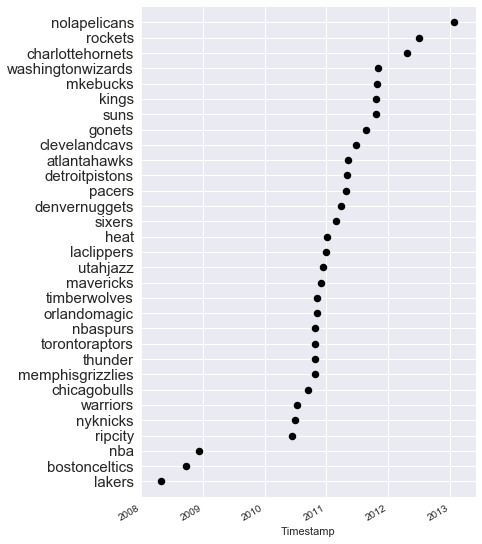

In [6]:
#Lets visually take a look at when these first submissions appeared per subreddit
plt.style.use('ggplot2')
#mapping y axis values for y team labels in graph below
val_dict = dict()
for i in range(len(earliest_subs)):
    val_dict[i+1] = str(earliest_subs.index[i].date()) + '-' + earliest_subs['subr_name'].iloc[i]

#making a list as well in correct ordinal order
subr_list = [val_dict[i].split('-')[3] for i in range(1,32)]


# make the plot
fig, ax = plt.subplots()
earliest_subs['yval'].plot(ax=ax, style='ks',ms=15,marker='.',figsize=(6,10));
ax.set_ylim([0,32])
ax.set_yticks(np.arange(1,32, 1.00));
ax.set_xlim(['2008-01-01','2013-06-01'])
ax.set_yticklabels(subr_list, fontsize=15);

#alternate way of setting custom y labels by using dict to map to y values
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))

#### Growth of the Reddit NBA Community: Total Posts per Month

Let's take a look at how the community has grown.

2013 :    
High Month: December
High Count: 6,539
Low Month: September
Low Count: 2,623
Total Posts for Year: 60,999
2014 :    
High Month: July
High Count: 13,206
Low Month: September
Low Count: 5,458
Total Posts for Year: 102,281
2015 :    
High Month: July
High Count: 16,964
Low Month: September
Low Count: 5,956
Total Posts for Year: 146,670
2016 :    
High Month: July
High Count: 20,712
Low Month: September
Low Count: 7,152
Total Posts for Year: 172,207
2017 :    
High Month: June
High Count: 31,018
Low Month: May
Low Count: 18,763
Total Posts for Year: 158,212


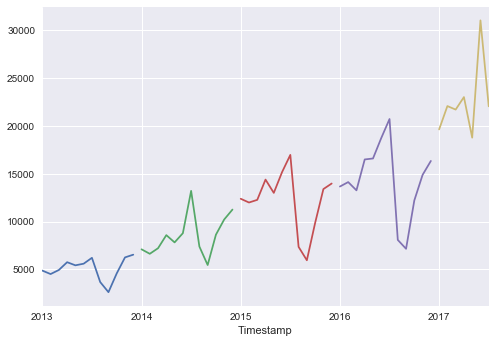

In [7]:
months_map = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

by_Month = nba_reddit.set_index('Timestamp').groupby(pd.TimeGrouper(freq='M'))['subr_name'].count()


#print each year for posts per month
for year in ['2013','2014','2015','2016','2017']:
    by_Month[year].plot()
    print(year+' :    ')
    print('High Month: {}'.format(months_map[by_Month[year].idxmax().month]))
    print('High Count: {:,}'.format(by_Month[year].max()))
    print('Low Month: {}'.format(months_map[by_Month[year].idxmin().month]))
    print('Low Count: {:,}'.format(by_Month[year].min()))
    print('Total Posts for Year: {:,}'.format(by_Month[year].sum()))
    
plt.style.use('ggplot')


nba_reddit = nba_reddit.reset_index()

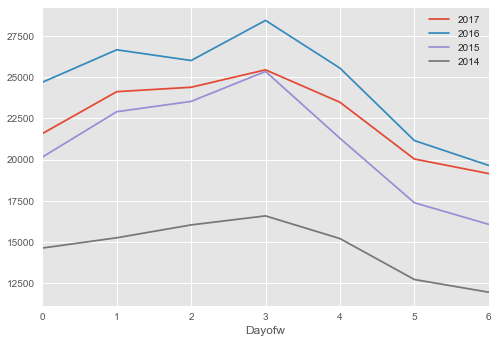

In [9]:
day_xticks = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday', 4:'Friday',5:'Saturday',6:'Sunday'}
nba_reddit['Year'] = nba_reddit['Timestamp'].apply(lambda x: x.year)
nba_reddit['Dayofw'] = nba_reddit['Timestamp'].apply(lambda x: x.dayofweek)



for yr in [2017,2016,2015,2014]:
    nba_reddit[nba_reddit['Year']==yr].groupby('Dayofw').count()['subr_name'].plot(label='{}'.format(yr))
    plt.legend()

ax.set_xticklabels(day_xticks);
    


In [ ]:
nba_reddit[nba_reddit['Year']==2014].groupby('Dayofw').count()['subr_name']